# Традиционный ноутбук начинающего DS

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

np.seterr(invalid='ignore')


from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Load source data

In [2]:
# import source data
file_path = 'https://raw.githubusercontent.com/a-milenkin/Datasetes_for_Piplines/main/responses.csv'
data = pd.read_csv(file_path)

# select target
interesting_features = ["Happiness in life", "Age", "Height", "Gender", "Weight", 
              "Left - right handed", "Village - town", "Getting up", "God",
              "Health", "Borrowed stuff", "Self-criticism", "Elections", 
              "Smoking", "Alcohol" ,"Number of friends", "Spending on healthy eating",
              "Music", "Movies", "Friends versus money", "Changing the past"]


target = ["Happiness in life"]

data = data[interesting_features]

### EDA

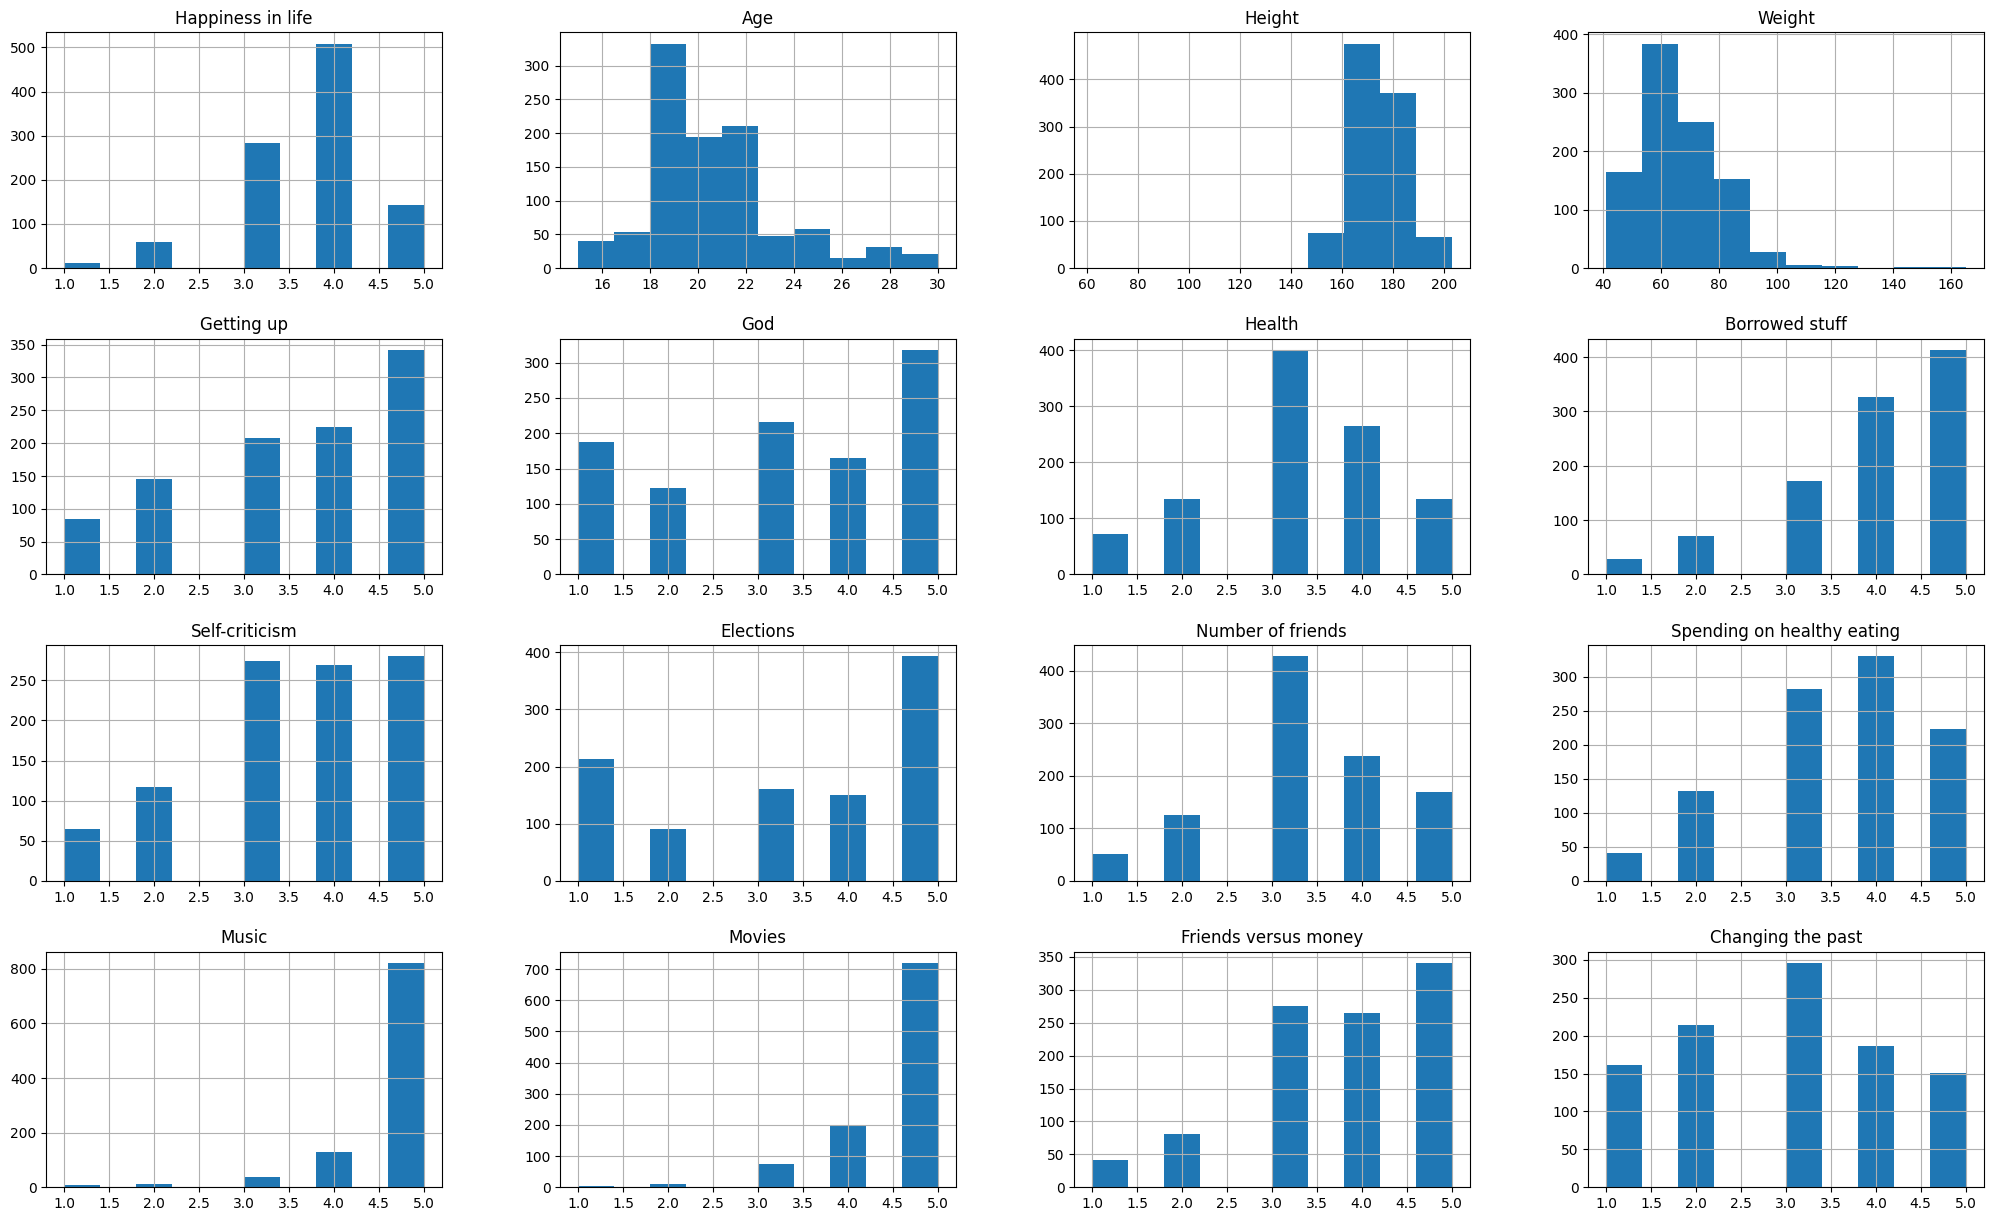

In [3]:
# hist
data.hist(figsize=(25, 15))
plt.show()

<AxesSubplot: >

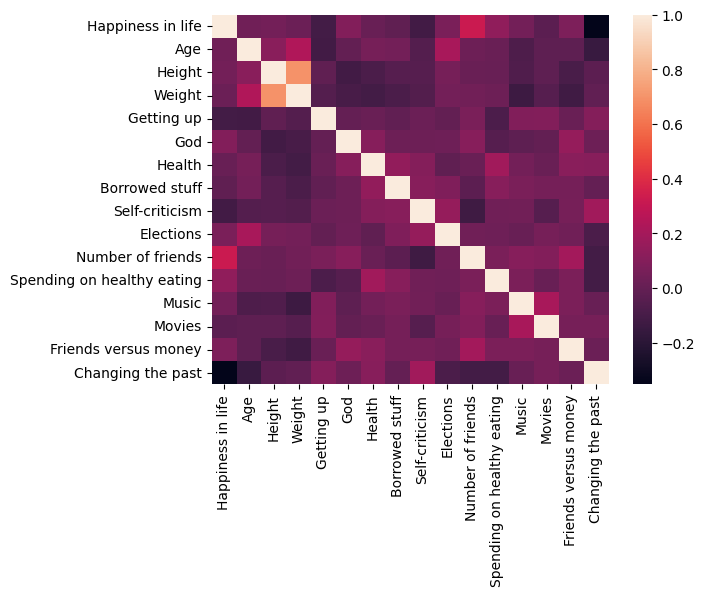

In [4]:
# heatmap
sns.heatmap(data.corr())

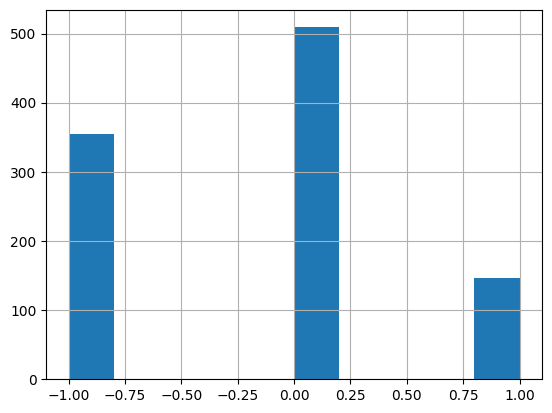

In [5]:
# balace classes

def happiness_score(x):
    if x < 4:
        return -1
    elif x == 4.0:
        return 0
    else:
        return 1
    
data["Happiness in life"] = data["Happiness in life"].apply(happiness_score)

data["Happiness in life"].hist();

### Preprocessing

In [6]:
# outliers
data.isnull().sum()

Happiness in life              0
Age                            7
Height                        20
Gender                         6
Weight                        20
Left - right handed            3
Village - town                 4
Getting up                     5
God                            2
Health                         1
Borrowed stuff                 2
Self-criticism                 5
Elections                      3
Smoking                        8
Alcohol                        5
Number of friends              0
Spending on healthy eating     2
Music                          3
Movies                         6
Friends versus money           6
Changing the past              2
dtype: int64

In [7]:
data.dropna(inplace=True)

In [8]:
# train test split
data_train, data_test = train_test_split(data, test_size=0.2, stratify=data[target])

In [9]:
# separate features

# numerical
numerical_features = ['Age', 'Height', 'Weight']  

# binars
to_dummies = [
    'Gender', 'Left - right handed', 'Village - town', 'Smoking',  "Alcohol" ,
]

# categorical
categorical_features = [
    col for col in data.columns if col not in numerical_features + target + to_dummies
]

all_features = categorical_features + numerical_features

In [10]:
scaler = StandardScaler() # Norm numerical
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')  # one hot encoding for categorical

In [11]:
data_train_scaled = scaler.fit_transform(data_train[numerical_features])

data_train_ohe = ohe.fit_transform(data_train[to_dummies])

In [12]:
data_train_tramsformed = pd.concat([pd.DataFrame(data_train_scaled, columns=numerical_features),
                                    pd.DataFrame(data_train_ohe, columns=ohe.get_feature_names())
                                   ], axis=1)

## ML

In [13]:
data_train_tramsformed.head()

,Age,Height,Weight,x0_female,x0_male,x1_left handed,x1_right handed,x2_city,x2_village,x3_current smoker,x3_former smoker,x3_never smoked,x3_tried smoking,x4_drink a lot,x4_never,x4_social drinker
0,-0.495991,1.045403,0.656558,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.205123,1.143178,0.434199,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.205123,-0.910103,-1.048189,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.256794,1.143178,3.991931,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.145434,0.360976,0.656558,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
model = LogisticRegression()

model.fit(data_train_tramsformed, data_train[target])

LogisticRegression()

In [15]:
preds = model.predict(data_train_tramsformed)


print(classification_report(data_train[target], preds))

              precision    recall  f1-score   support

          -1       0.53      0.03      0.07       259
           0       0.51      0.98      0.67       374
           1       0.33      0.01      0.02       107

    accuracy                           0.51       740
   macro avg       0.46      0.34      0.25       740
weighted avg       0.49      0.51      0.37       740



## Validation

In [16]:
# test preprocessing
data_test_scaled = scaler.transform(data_test[numerical_features])
data_test_ohe = ohe.transform(data_test[to_dummies])

data_test_tramsformed = pd.concat([pd.DataFrame(data_test_scaled, columns=numerical_features),
                                    pd.DataFrame(data_test_ohe, columns=ohe.get_feature_names())
                                  ], axis=1)

In [17]:
preds = model.predict(data_test_tramsformed)

print(classification_report(data_test[target], preds))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        65
           0       0.50      0.98      0.66        93
           1       0.00      0.00      0.00        27

    accuracy                           0.49       185
   macro avg       0.17      0.33      0.22       185
weighted avg       0.25      0.49      0.33       185



# Make pipeline

## Imports

In [18]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

## preprocessing

In [19]:
#   Numerical - SimpleImputer + StandardScaler
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("fs", SelectKBest(score_func=f_classif, k="all")),
])

#   Categorical - SimpleImputer + OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

In [20]:
# Собираем воедино трансформеры для числовых и категориальных признаков
data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features),
])

# Создание конвейера препроцессора, который сначала преобразует данные
preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression(solver='liblinear'))])

classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'Height',
                                                                    'Weight']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Getting '
                                                                    'up',
                                                                    'God',
                                                                    'Health',
                                                                    'Borrowed '
                                                                    'stuff',
                                                                    'Self-criticism',
                                                                    'Elections',
                                                                    'Number of '
                                                                    'friends',
                                                                    'Spending '
                                                                    'on '
                                                                    'healthy '
                                                                    'eating',
                                                                    'Music',
                                                                    'Movies',
                                                                    'Friends '
                                                                    'versus '
                                                                    'money',
                                                                    'Changing '
                                                                    'the '
                                                                    'past'])]))])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [21]:
data_train, data_test = train_test_split(data[all_features + target], test_size=0.2, stratify=data[target])

In [22]:
classifier_pipline.fit(data_train[all_features], data_train[target])

preds = classifier_pipline.predict(data_test[all_features])

print(classification_report(data_test[target], preds))

              precision    recall  f1-score   support

          -1       0.57      0.51      0.54        65
           0       0.61      0.75      0.67        93
           1       0.58      0.26      0.36        27

    accuracy                           0.59       185
   macro avg       0.59      0.51      0.52       185
weighted avg       0.59      0.59      0.58       185



## Tuning hyperparameters

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score, average="macro")

In [24]:
param_grid = {
    'classifier__C': np.logspace(-5, 2, 100), # np.linspace(-10, 10)
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': ['balanced', None],
    
    'preprocessor__data_transformer__numerical__imputer__strategy':['median', 'mean']
}


search = GridSearchCV(classifier_pipline, param_grid, n_jobs=-1, cv=3, scoring=f1)

search.fit(data_train.drop(target, axis=1), data_train[target].values.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           StandardScaler()),
                                                                                                          ('fs',
                                                                                                           SelectKBest(k='all'))]),
                                                                                          ['Age',
                                                                                           'Height',
                                                                                           'Weight']),
                                                                                         ('categorical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('onehot',
                                                                                                           OneHotEncod...
       1.66810054e+01, 1.96304065e+01, 2.31012970e+01, 2.71858824e+01,
       3.19926714e+01, 3.76493581e+01, 4.43062146e+01, 5.21400829e+01,
       6.13590727e+01, 7.22080902e+01, 8.49753436e+01, 1.00000000e+02]),
                         'classifier__class_weight': ['balanced', None],
                         'classifier__penalty': ['l1', 'l2'],
                         'preprocessor__data_transformer__numerical__imputer__strategy': ['median',
                                                                                          'mean']},
             scoring=make_scorer(f1_score, average=macro))

In [25]:
search.best_params_

{'classifier__C': 0.14849682622544635,
 'classifier__class_weight': 'balanced',
 'classifier__penalty': 'l1',
 'preprocessor__data_transformer__numerical__imputer__strategy': 'median'}

In [26]:
search.best_score_

0.520226021175656

In [27]:
search = RandomizedSearchCV(classifier_pipline, param_grid, n_jobs=-1, cv=3, scoring=f1)

search.fit(data_train.drop(target, axis=1), data_train[target].values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('data_transformer',
                                                               ColumnTransformer(transformers=[('numerical',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer()),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler()),
                                                                                                                ('fs',
                                                                                                                 SelectKBest(k='all'))]),
                                                                                                ['Age',
                                                                                                 'Height',
                                                                                                 'Weight']),
                                                                                               ('categorical',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer()),
                                                                                                                ('onehot',
                                                                                                                 OneHo...
       1.66810054e+01, 1.96304065e+01, 2.31012970e+01, 2.71858824e+01,
       3.19926714e+01, 3.76493581e+01, 4.43062146e+01, 5.21400829e+01,
       6.13590727e+01, 7.22080902e+01, 8.49753436e+01, 1.00000000e+02]),
                                        'classifier__class_weight': ['balanced',
                                                                     None],
                                        'classifier__penalty': ['l1', 'l2'],
                                        'preprocessor__data_transformer__numerical__imputer__strategy': ['median',
                                                                                                         'mean']},
                   scoring=make_scorer(f1_score, average=macro))

In [28]:
search.best_params_

{'preprocessor__data_transformer__numerical__imputer__strategy': 'median',
 'classifier__penalty': 'l2',
 'classifier__class_weight': 'balanced',
 'classifier__C': 16.68100537200059}

In [29]:
search.best_score_

0.4900281201202851

## Several estimators

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost

clf1 = LogisticRegression(multi_class="multinomial", random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

blending_classifier = VotingClassifier(
    estimators=[("log_regrassion", clf1), 
                ("random_forest", clf2), 
                ("gnb", clf3)] 
)
blending_classifier

VotingClassifier(estimators=[('log_regrassion',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('random_forest',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB())])

In [31]:
classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", blending_classifier)]
)

classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'Height',
                                                                    'Weight']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))...
                                                                    'Elections',
                                                                    'Number of '
                                                                    'friends',
                                                                    'Spending '
                                                                    'on '
                                                                    'healthy '
                                                                    'eating',
                                                                    'Music',
                                                                    'Movies',
                                                                    'Friends '
                                                                    'versus '
                                                                    'money',
                                                                    'Changing '
                                                                    'the '
                                                                    'past'])]))])),
                ('classifier',
                 VotingClassifier(estimators=[('log_regrassion',
                                               LogisticRegression(multi_class='multinomial',
                                                                  random_state=1)),
                                              ('random_forest',
                                               RandomForestClassifier(n_estimators=50,
                                                                      random_state=1)),
                                              ('gnb', GaussianNB())]))])

## Add Stekking

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier

In [33]:
# get estimators
estimators = [
    ("Random_Forest", RandomForestClassifier()),
    ("Xgboost", xgboost.XGBClassifier()),
    ("SVM", LinearSVC()),
    
]

# build classifier
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(n_jobs=-1, verbose=True),
    n_jobs=-1,
    verbose=True,
)

classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", stacking_classifier)]
)

classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'Height',
                                                                    'Weight']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))...
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...)),
                                                ('SVM', LinearSVC())],
                                    final_estimator=LogisticRegression(n_jobs=-1,
                                                                       verbose=True),
                                    n_jobs=-1, verbose=True))])

## Compile

In [34]:
from sklearn.decomposition import PCA

# get estimators
estimators = [
    ("SVM", make_pipeline(preprocessor, PCA(), LinearSVC())),
    ("Random_Forest", make_pipeline(preprocessor, RandomForestClassifier())),
    ("Xgboost", make_pipeline(preprocessor, xgboost.XGBClassifier())),
]

# build classifier
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(n_jobs=-1, verbose=True),
    n_jobs=-1,
    verbose=True,
)

stacking_classifier

StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('data_transformer',
                                                                  ColumnTransformer(transformers=[('numerical',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer()),
                                                                                                                   ('scaler',
                                                                                                                    StandardScaler()),
                                                                                                                   ('fs',
                                                                                                                    SelectKBest(k='all'))]),
                                                                                                   ['Age',
                                                                                                    'Height',
                                                                                                    'Weight']),
                                                                                                  ('categorical',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer()),
                                                                                                                   ('onehot',
                                                                                                                    OneHo...
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))]))],
                   final_estimator=LogisticRegression(n_jobs=-1, verbose=True),
                   n_jobs=-1, verbose=True)

# Итоги

## Сколько всего кода требуется

In [35]:
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("feature_selector", SelectKBest(score_func=f_classif, k="all"))])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features)])

preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

estimators = [
    ("SVM", make_pipeline(preprocessor, LinearSVC(max_iter=10000))),
    ("Random_Forest", make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1))),
    ("xgboost", make_pipeline(preprocessor, xgboost.XGBClassifier(n_jobs=-1)))]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

stacking_classifier.fit(data[interesting_features], data[target])

/Users/stureiko/miniforge3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1017: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/Users/stureiko/miniforge3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1017: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('data_transformer',
                                                                  ColumnTransformer(transformers=[('numerical',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer()),
                                                                                                                   ('scaler',
                                                                                                                    StandardScaler()),
                                                                                                                   ('feature_selector',
                                                                                                                    SelectKBest(k='all'))]),
                                                                                                   ['Age',
                                                                                                    'Height',
                                                                                                    'Weight']),
                                                                                                  ('categorical',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer()),
                                                                                                                   (...
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=-1,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))]))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [36]:
preds = stacking_classifier.predict(data[interesting_features])

print(classification_report(data[target], preds))

              precision    recall  f1-score   support

          -1       0.91      0.89      0.90       324
           0       0.94      1.00      0.97       467
           1       0.94      0.79      0.86       134

    accuracy                           0.93       925
   macro avg       0.93      0.89      0.91       925
weighted avg       0.93      0.93      0.93       925

